**Chapter 15 – Processing Sequences Using RNNs**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM


# Common imports
import numpy as np
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# To make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Basic RNNs

## Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):
    freq, offsets = np.random.rand(2, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets) * (freq * 10 + 10))  #   wave
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

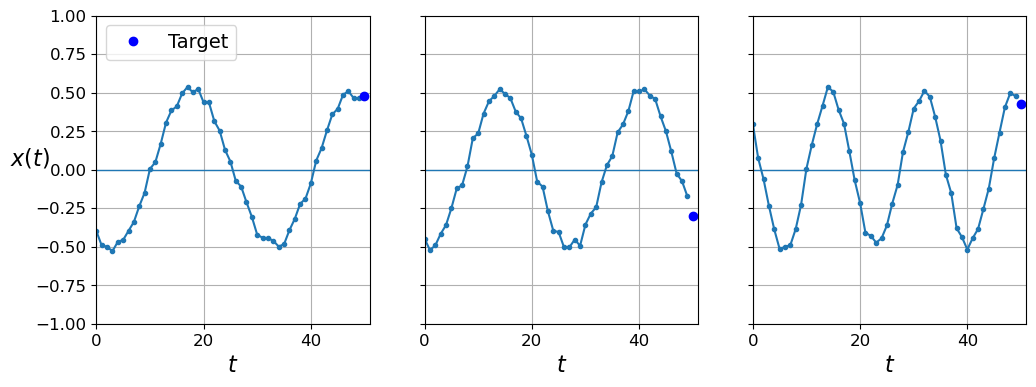

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

**Note**: in this notebook, the blue dots represent targets, and red crosses represent predictions.

## Computing Some Baselines

Naive predictions (just predict the last observed value):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.0132797705

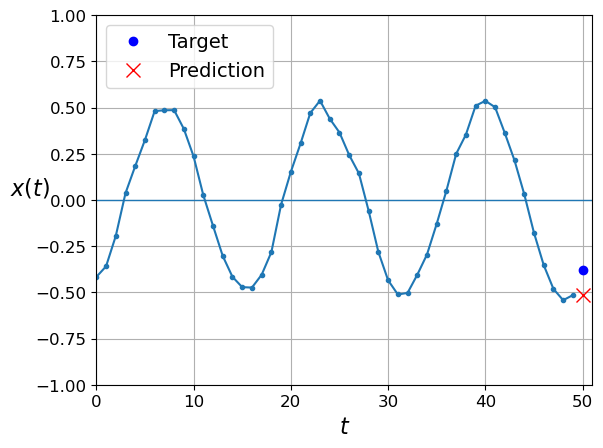

In [7]:
y_pred = X_test[:, -1]
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

Linear predictions:

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(Flatten(input_shape=[50, 1]))
model.add(Dense(1))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51 (204.00 Byte)
Trainable params: 51 (204.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.2200 - val_loss: 0.0629
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0378 - val_loss: 0.0213
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0134 - val_loss: 0.0091
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 5/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0036 - val_loss: 0.0035

In [12]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0023


0.0022597929928451777

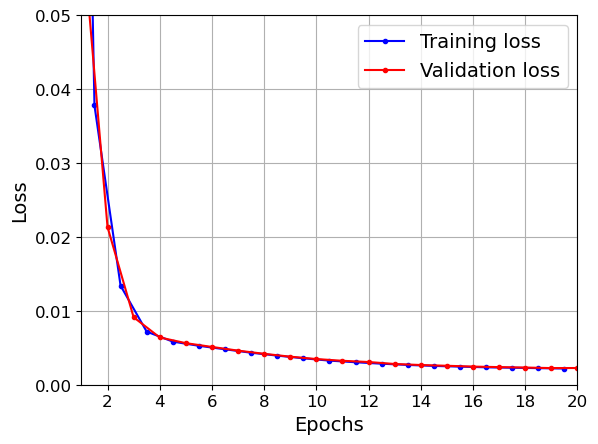

In [13]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

32/32 [==============================] - 0s 3ms/step


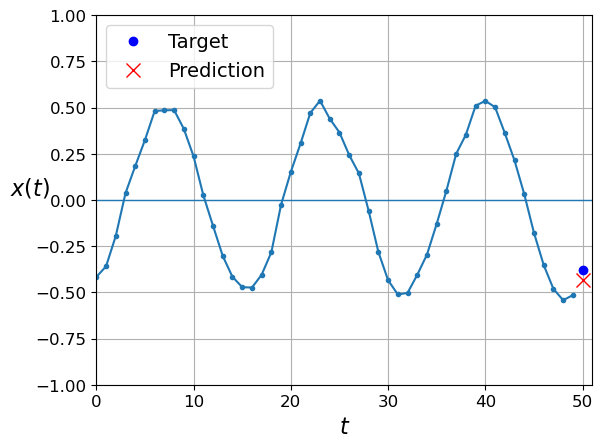

In [14]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

## Using a Simple RNN

In [15]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(SimpleRNN(1, input_shape=[50, 1]))

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3 (12.00 Byte)
Trainable params: 3 (12.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 8s 25ms/step - loss: 0.2097 - val_loss: 0.1385
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0956 - val_loss: 0.0594
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0356 - val_loss: 0.0202
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0129 - val_loss: 0.0096
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 7/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 8/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 9/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0081 - val_loss: 0.0082
Epoch 10/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0081 - val_lo

In [19]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0082


0.008248766884207726

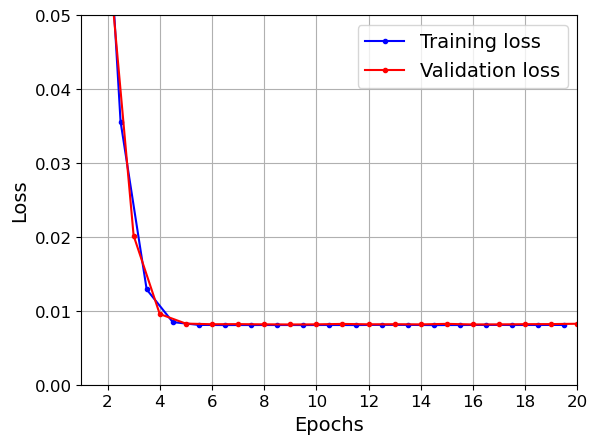

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

32/32 [==============================] - 1s 8ms/step


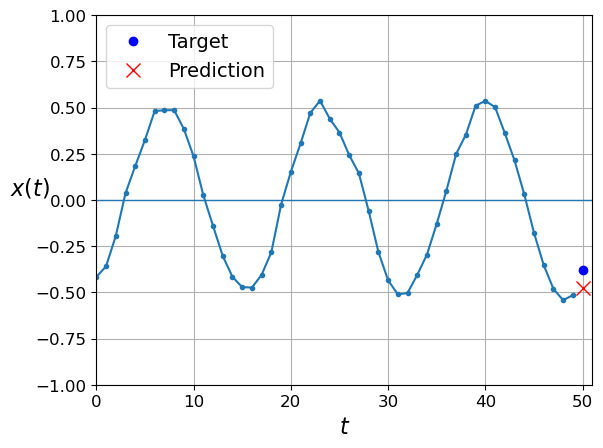

In [21]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()

# LSTMs

In [22]:
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()
model.add(LSTM(1, input_shape=[50, 1]))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [25]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 15s 46ms/step - loss: 0.1629 - val_loss: 0.1474
Epoch 2/20
219/219 [==============================] - 9s 40ms/step - loss: 0.1339 - val_loss: 0.1241
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.1144 - val_loss: 0.1077
Epoch 4/20
219/219 [==============================] - 9s 40ms/step - loss: 0.1007 - val_loss: 0.0962
Epoch 5/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0910 - val_loss: 0.0881
Epoch 6/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0840 - val_loss: 0.0821
Epoch 7/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0787 - val_loss: 0.0773
Epoch 8/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0742 - val_loss: 0.0730
Epoch 9/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0697 - val_loss: 0.0681
Epoch 10/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0641 - val_l

In [26]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0094


0.00936143472790718

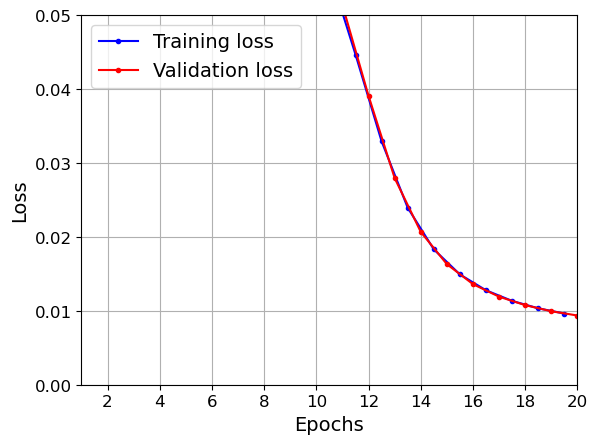

In [27]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

32/32 [==============================] - 1s 8ms/step


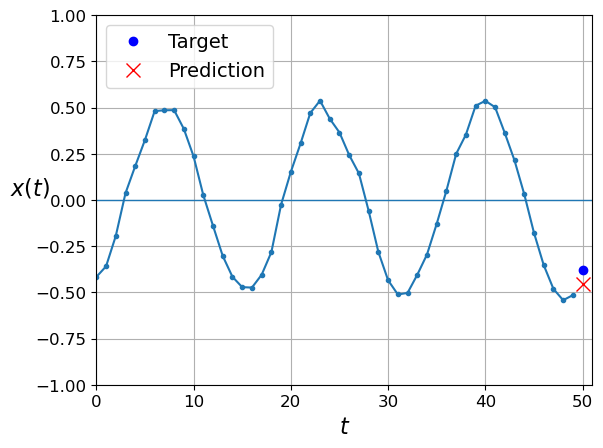

In [28]:
y_pred = model.predict(X_test)
plot_series(X_test[0, :, 0], y_test[0, 0], y_pred[0, 0])
plt.show()